# Langgraph-subgraph

Sử dụng **SubGraphs** cho phép bạn xây dựng các hệ thống phức tạp chứa nhiều thành phần, trong đó bản thân các thành phần này có thể trở thành các đồ thị. Một trường hợp sử dụng phổ biến cho **SubGraphs** là xây dựng các hệ thống đa tác tử (multi-agent systems).

Cân nhắc chính khi thêm **SubGraphs** là cách đồ thị cha và SubGraph giao tiếp, cụ thể là cách chúng truyền trạng thái cho nhau trong quá trình thực thi đồ thị.

- Có hai kịch bản:
1. Khi đồ thị cha và `subgraph` **chia sẻ các khóa schema**. Trong trường hợp này, bạn có thể thêm các nút với `subgraph` đã được biên dịch.
2. Khi đồ thị cha và `subgraph` có **các schema khác nhau**. Trong trường hợp này, bạn cần thêm một **node function** gọi `subgraph`.

Điều này hữu ích khi đồ thị cha và `subgraph` có các schema trạng thái khác nhau và trạng thái cần được chuyển đổi trước và sau khi gọi `subgraph`.

Tôi sẽ chỉ cho bạn cách thêm subgraphs cho từng kịch bản bên dưới.


## Case 1: When Sharing Schema Keys

### Adding Nodes with Compiled SubGraphs

Đây là một trường hợp phổ biến khi đồ thị cha (parent graph) và đồ thị con (subgraph) giao tiếp thông qua các khóa trạng thái được chia sẻ (shared state keys).
Ví dụ: trong các hệ thống đa tác tử (multi-agent systems), các tác tử thường giao tiếp thông qua khóa '`messages`' được chia sẻ.
Khi một **đồ thị con chia sẻ các khóa trạng thái với đồ thị cha**, bạn có thể thêm nó vào đồ thị theo các bước sau:

1. Định nghĩa và biên dịch quy trình làm việc `subgraph` (`subgraph_builder` trong ví dụ bên dưới)
2. Truyền `subgraph` đã biên dịch vào phương thức `.add_node` khi định nghĩa quy trình làm việc của đồ thị cha.


In [1]:
from langgraph.graph import START, END, StateGraph
from typing import TypedDict


# TypedDict class for defining subgraph state, including name key shared with parent graph and family_name key exclusive to subgraph
class ChildState(TypedDict):
    name: str  # State key shared with parent graph
    family_name: str


# First node of subgraph, sets initial value for family_name key
def subgraph_node_1(state: ChildState):
    return {"family_name": "Lee"}


# Second node of subgraph, combines subgraph-exclusive family_name key and shared name key to create new state
def subgraph_node_2(state: ChildState):
    # Perform update using family_name key only available within subgraph and shared state key name
    return {"name": f'{state["name"]} {state["family_name"]}'}


# Define subgraph structure and set node connection relationships
subgraph_builder = StateGraph(ChildState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()

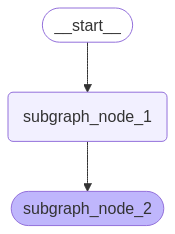

In [3]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Visualize the graph
display(
    Image(
        subgraph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [4]:
# TypedDict class for defining parent graph state, containing only the name key
class ParentState(TypedDict):
    name: str
    company: str


# First node of parent graph, modifies the name key value to create new state
def node_1(state: ParentState):
    return {"name": f'My name is {state["name"]}'}


# Define parent graph structure and set node connection relationships including subgraph
builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
# Add compiled subgraph as a node to parent graph
builder.add_node("node_2", subgraph)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)
graph = builder.compile()

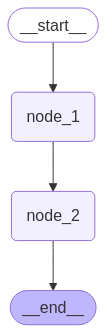

In [5]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Visualize the graph
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [6]:
# Stream graph data chunk by chunk and print each chunk
for chunk in graph.stream({"name": "Teddy"}):
    print(chunk)

{'node_1': {'name': 'My name is Teddy'}}
{'node_2': {'name': 'My name is Teddy Lee'}}


Đầu ra cuối cùng của đồ thị cha bao gồm kết quả của các lệnh gọi đồ thị con (subgraph calls).

Để kiểm tra đầu ra của đồ thị con, bạn có thể chỉ định `subgraphs=True` khi phát trực tuyến (streaming).


In [7]:
# Stream and output subgraph data chunks sequentially
# Process streaming with subgraphs by setting subgraphs=True
for chunk in graph.stream({"name": "Teddy"}, subgraphs=True):
    print(chunk)

((), {'node_1': {'name': 'My name is Teddy'}})
(('node_2:08f29f8f-45c0-5c26-1910-5c8c8e483150',), {'subgraph_node_1': {'family_name': 'Lee'}})
(('node_2:08f29f8f-45c0-5c26-1910-5c8c8e483150',), {'subgraph_node_2': {'name': 'My name is Teddy Lee'}})
((), {'node_2': {'name': 'My name is Teddy Lee'}})
